Buisness Objective:

    build the model to segment mall customers.

In [1]:
# Importing necessary libraries 
import pandas as pd
import numpy as np

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#for preprocessing
from sklearn.preprocessing import MinMaxScaler

# For model
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import silhouette_visualizer 
from yellowbrick.cluster import kelbow_visualizer
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering,DBSCAN
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing datastet
df = pd.read_csv('DS3_C6_S3_MallCustomers_Data_Project.csv')
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


## Data Understanding

In [3]:
#shape
df.shape

(200, 5)

In [4]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
#statistical summary
df.describe([0.25,0.75,0.90,0.95])

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
90%,180.100000,59.100000,93.400000,87.100000
95%,190.050000,66.050000,103.000000,92.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
#if any special char present in the dataset.replacing special char to nan
df=df.replace(to_replace=[" ?","?","!","@","/"],value=np.nan)

In [7]:
#checking null values
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

There is no null value present in our dataset.

## EDA

In [8]:
sns.set_style('darkgrid')

In [9]:
df['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

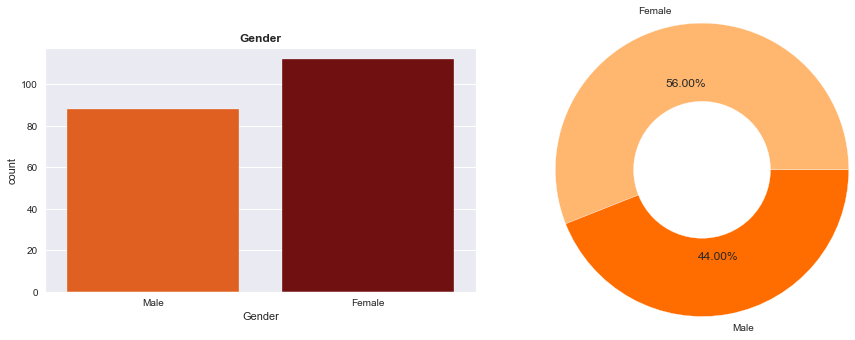

In [10]:
plt.figure(figsize=(13,5))

plt.subplot(121)
sns.countplot(df['Gender'],palette='gist_heat_r')
plt.title('Gender',fontdict={'fontweight':'bold'})

value = df['Gender'].value_counts()
label = ['Female','Male']
plt.subplot(122)
palette_color = sns.color_palette('gist_heat_r')
plt.pie(value,labels=label,autopct='%.2f%%',radius=1.5,colors=palette_color)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.tight_layout()
plt.show()

* We can see from the plots around 56% customers are female and 44% customers are males.

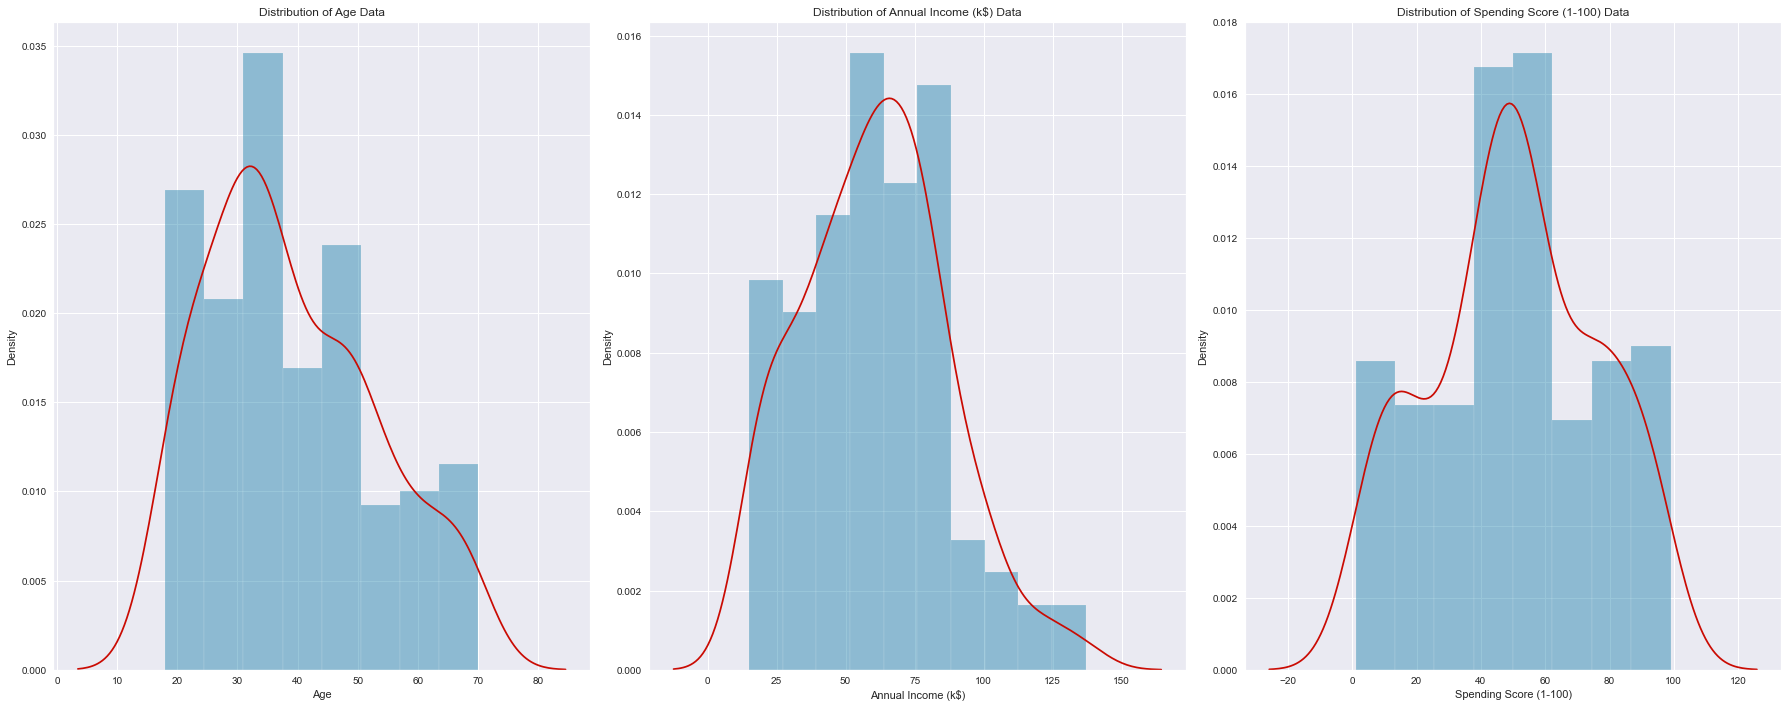

In [11]:
numeric_feat = [col for col in df.columns if df[col].dtype =='int64' and not col=='CustomerID' ]
plt.figure(figsize=(25,10))
for i,col in enumerate(numeric_feat,1):
    plt.subplot(1,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.distplot(df[col],kde=True,kde_kws={'color':'r'},hist_kws={'color':'b'})
    plt.tight_layout()
    plt.plot()

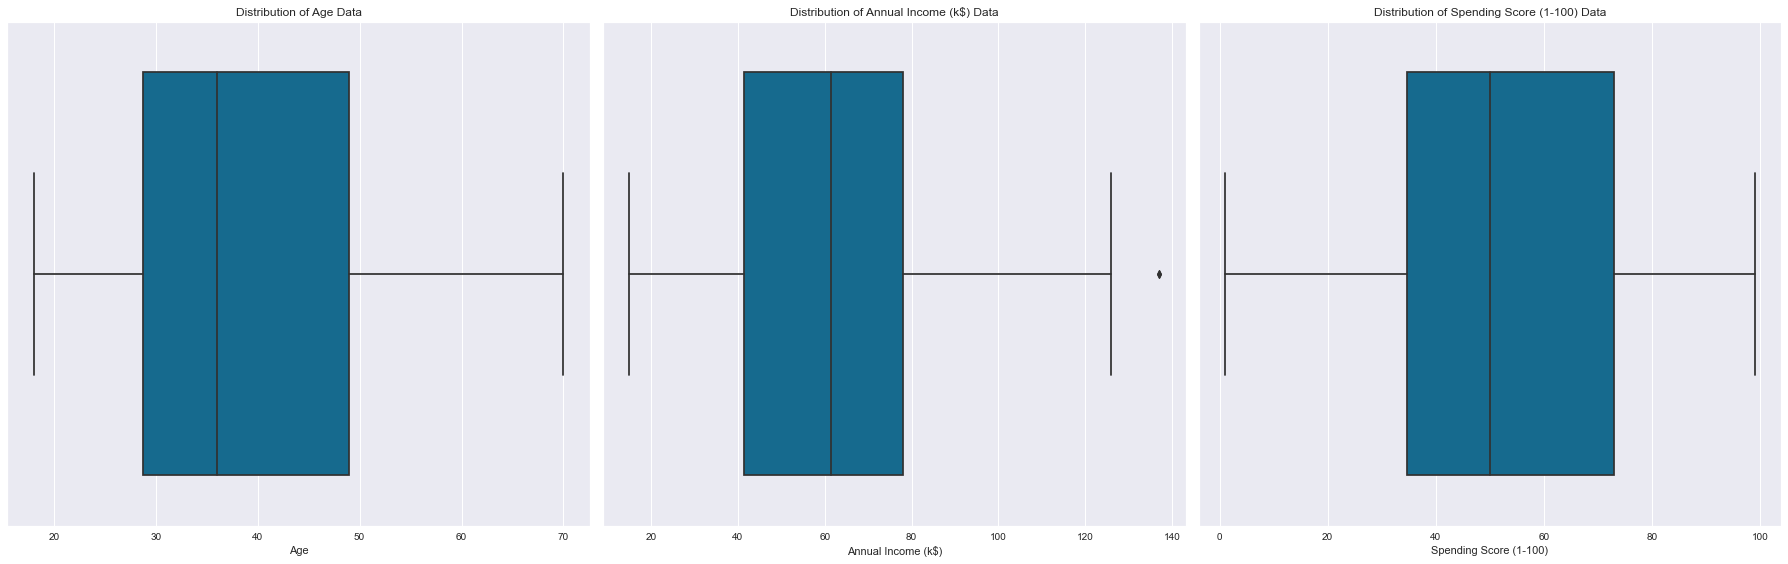

In [12]:
plt.figure(figsize=(25,8))
for i,col in enumerate(numeric_feat,1):
    plt.subplot(1,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.boxplot(df[col])
    plt.tight_layout()
    plt.plot()

* All numerical features distributions looks like normal distribution.

* And there is no significant outliers present.

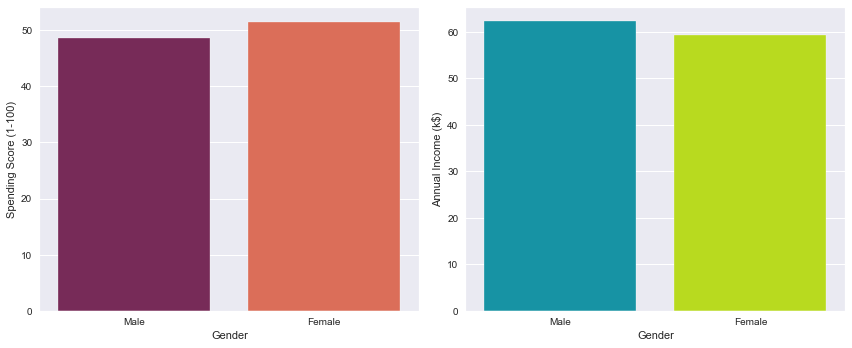

In [13]:
#gender wise spending score and Annual income
plt.subplots(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot('Gender','Spending Score (1-100)',data=df,ci=False,palette='rocket')

plt.subplot(1,2,2)
sns.barplot('Gender','Annual Income (k$)',data=df,ci=False,palette='nipy_spectral')

plt.tight_layout()
plt.show()


* Males avg annual income is slightly high compared to females.
* Though males are earning more compared to females, their spending score is less compared to females.

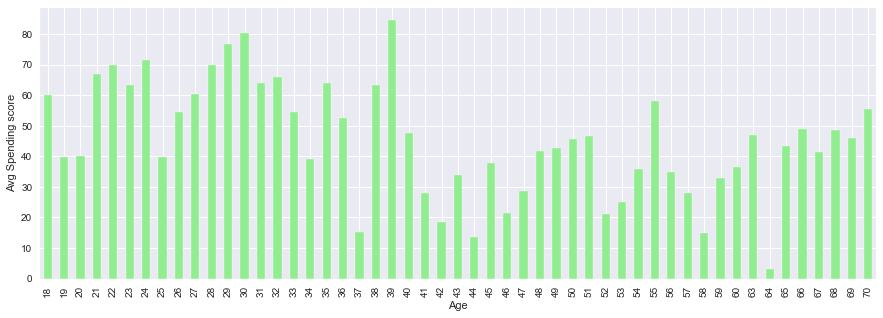

In [14]:
#age wise spending score
df.groupby(by=['Age'])['Spending Score (1-100)'].mean().plot(kind='bar',figsize=(15,5),color='lightgreen',
                                                             ylabel='Avg Spending score')
plt.show()

* We can see from the plot mostly 20 to 40 age group peoples are spending more. 

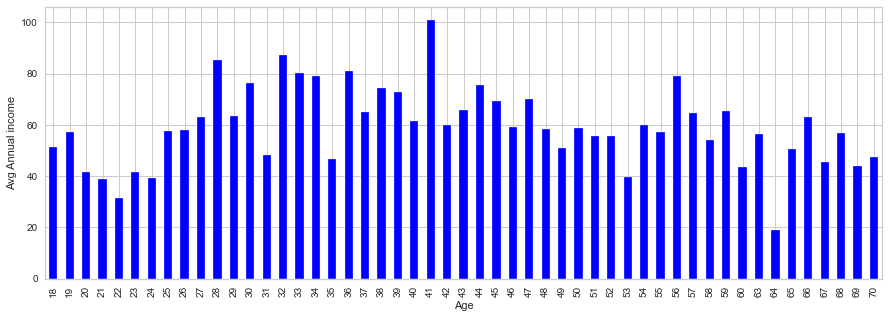

In [39]:
#age wise Annual income
df.groupby(by=['Age'])['Annual Income (k$)'].mean().plot(kind='bar',figsize=(15,5),color='blue',
                                                             ylabel='Avg Annual income')
plt.show()

* 24 to 50 age group peoples Annual income is high

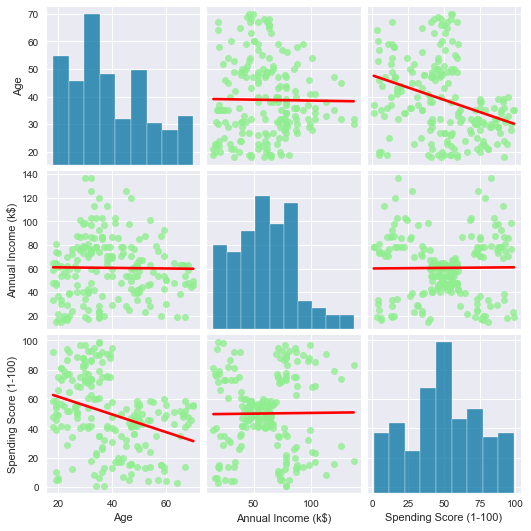

In [16]:
pair = df.drop(columns=['CustomerID'],axis=1)
sns.pairplot(pair,kind='reg',plot_kws={'ci':None,'color':'red','scatter_kws':{'color':'lightgreen'}})
plt.show()

* Age and Spending score slightly negative correlation.Means Aged peoples are spending less

## Preprocessing

In [17]:
#dropping 'CustomerID','Gender'  columns
df.drop(columns=['CustomerID','Gender'],axis=1,inplace=True)

In [18]:
#scaling
scaler = MinMaxScaler()
X=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
X.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,0.019231,0.000000,0.387755
1,0.057692,0.000000,0.816327
2,0.038462,0.008197,0.051020
3,0.096154,0.008197,0.775510
4,0.250000,0.016393,0.397959


## Modelling

### 1.kmeans clustering

In [19]:
model1 = KMeans()

We need to choose the number of clusters and for doing this, we’ll use silhouette_score and elbow method.

In [20]:
for i in range(2,11):
    model=KMeans(n_clusters=i)
    model.fit(X)
    labels=model.labels_
    silhouette_avg=silhouette_score(X,labels)
    print("For n_clusters =", i,"The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.3652498066402899
For n_clusters = 3 The average silhouette_score is : 0.36504262943838
For n_clusters = 4 The average silhouette_score is : 0.392319202055722
For n_clusters = 5 The average silhouette_score is : 0.40611743307078185
For n_clusters = 6 The average silhouette_score is : 0.4234860620777653
For n_clusters = 7 The average silhouette_score is : 0.4225151742961545
For n_clusters = 8 The average silhouette_score is : 0.41762763591840657
For n_clusters = 9 The average silhouette_score is : 0.4279246022375552
For n_clusters = 10 The average silhouette_score is : 0.39873251370313645


For finding optimum n_clusters(k)value by elbow method

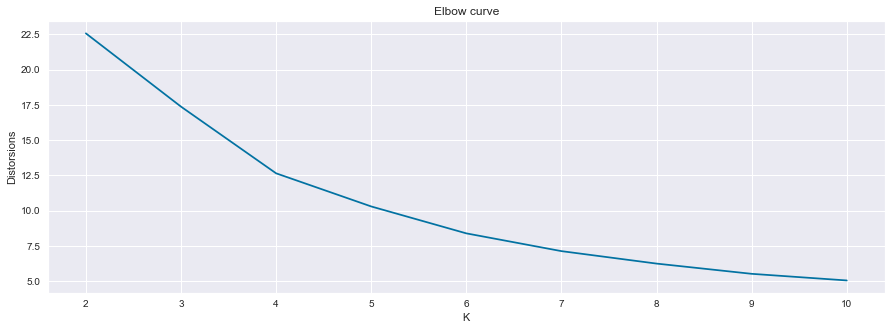

In [21]:
# Finding best k value by elbow method
distorsions = []
for i in range(2,11):
    m = KMeans(n_clusters=i)
    m.fit(X)
    distorsions.append(m.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), distorsions)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Distorsions')
plt.title('Elbow curve');

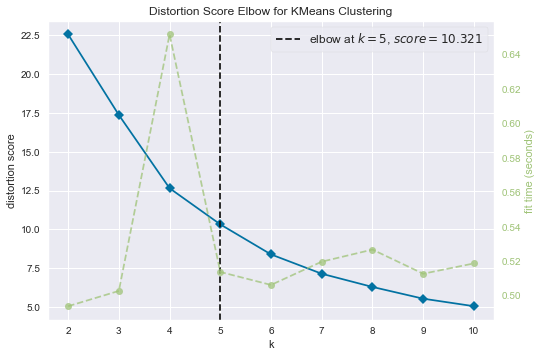

In [22]:
kv = kelbow_visualizer(model1, X, k=(2,11))

* We can fix k value as 5 by this elbow method.

In [23]:
#model building with optimum kvalue(5)
kmeans_model = KMeans(n_clusters=5)
kmeans_model.fit(X)
labels = kmeans_model.labels_

labels1 =pd.DataFrame(labels,columns=['Kmean cluster'])
df = pd.concat([df,labels1],axis=1)

In [24]:
sh_score = silhouette_score(X,labels)
print("Silhoutte score of kmeans:",round(sh_score,3))

Silhoutte score of kmeans: 0.406


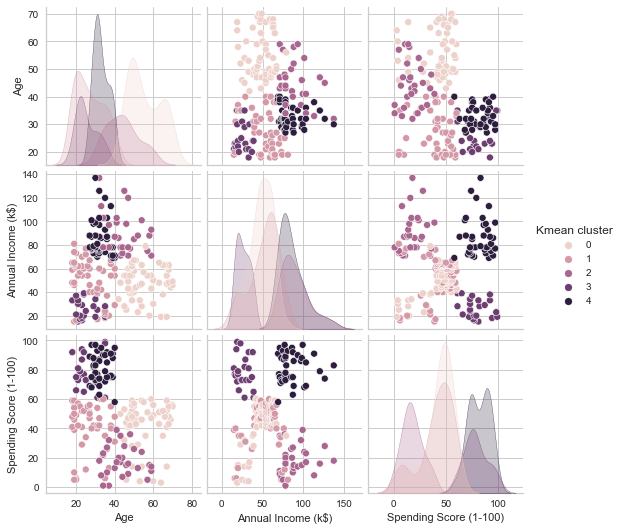

In [25]:
sns.set_style('whitegrid')
sns.pairplot(df,hue='Kmean cluster')
plt.show()

* We can see clusters with each pair of features. 

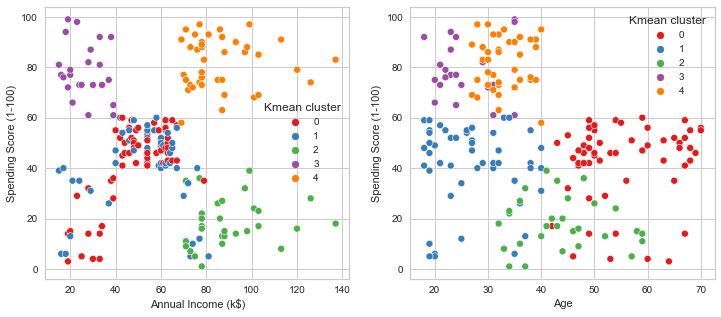

In [40]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=df,
                hue='Kmean cluster', ax=axes[0], palette='Set1')

sns.scatterplot('Age', 'Spending Score (1-100)', data=df,
                hue='Kmean cluster', palette='Set1', ax=axes[1])


plt.show()

K-Means algorithm generated the following 5 clusters:

  * cluster 3--clients with low annual income and high spending score
  * cluster 1--clients with medium annual income and medium spending score
  * cluster 2--clients with high annual income and low spending score
  * cluster 4--clients with high annual income and high spending score
  * cluster 0--clients with low annual income and low spending score


### 2.Hierarchical clustering

For Hierarchical clustering, We need to choose the number of clusters and for doing this, we’ll use Dendrograms.

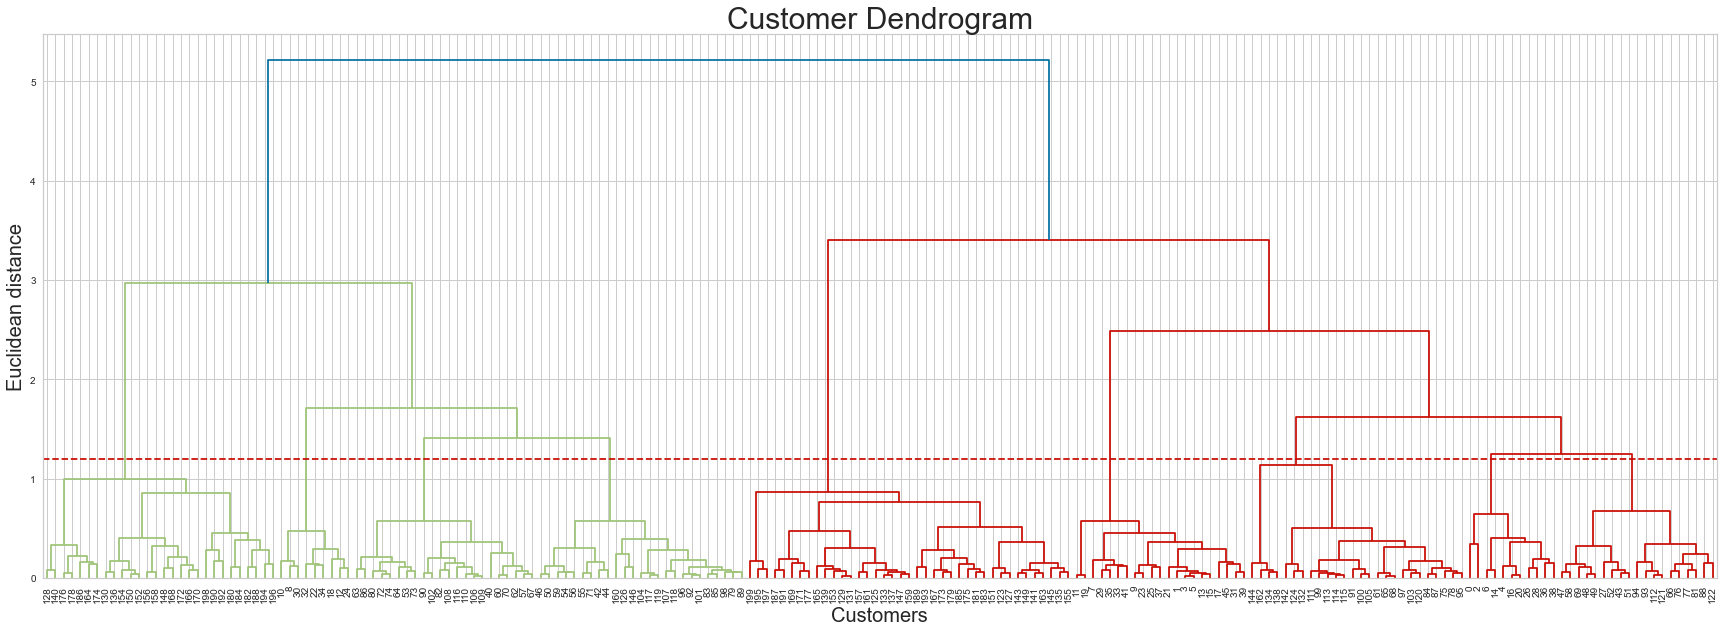

In [27]:
# dendrogram--linkage-->ward
plt.figure(figsize=(30, 10))
dendrogram = sch.dendrogram(sch.linkage(X,method='ward'))
plt.axhline(y=1.2, color='r', linestyle='--')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('Customer Dendrogram',fontsize=30)
plt.xlabel('Customers',fontsize=20)
plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

* For ward linkage,our threshold value 1.2 and clusters are 8.

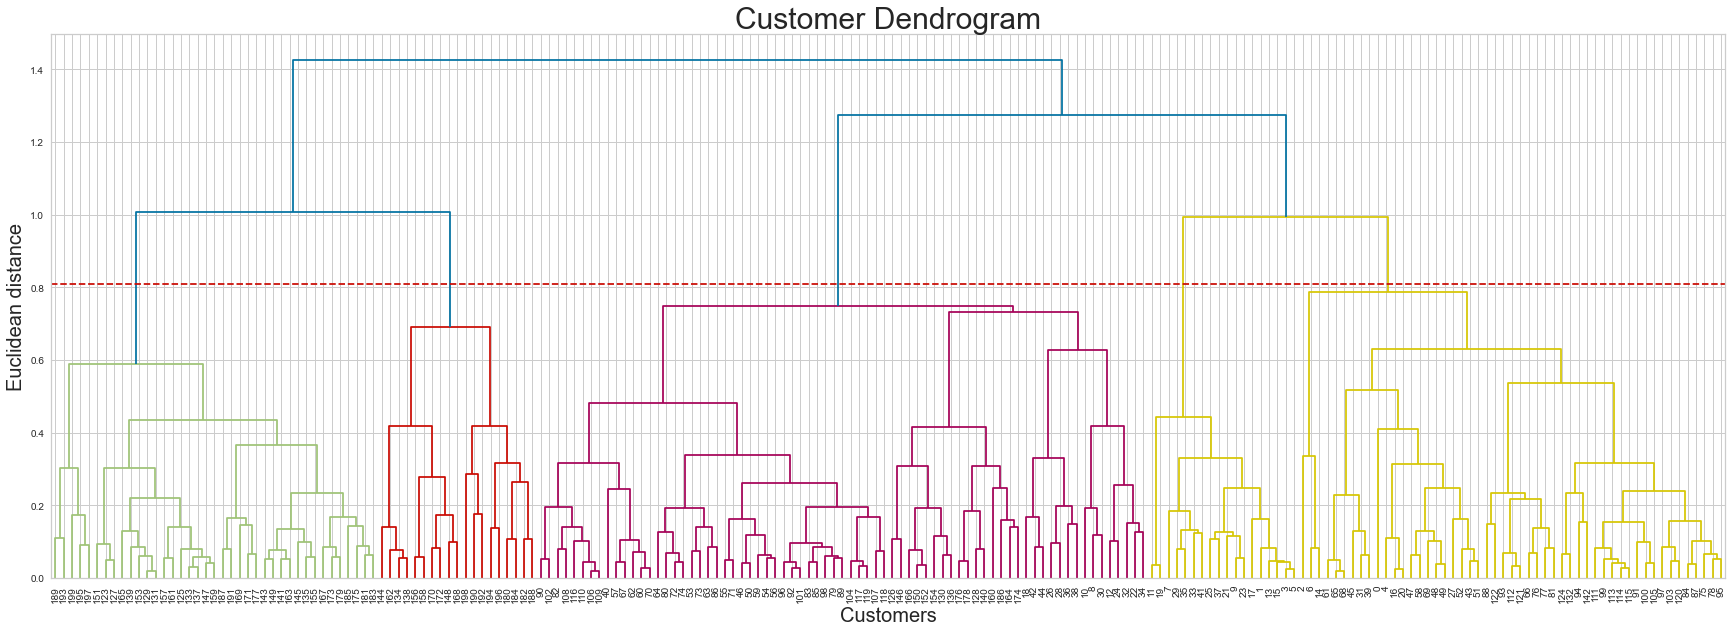

In [28]:
# dendrogram--linkage-->complete
plt.figure(figsize=(30, 10))
dendrogram = sch.dendrogram(sch.linkage(X,method='complete'))
plt.axhline(y=0.81, color='r', linestyle='--')
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=10)
plt.title('Customer Dendrogram',fontsize=30)
plt.xlabel('Customers',fontsize=20)
plt.ylabel('Euclidean distance', fontsize=20)
plt.show()

* For complete linkage,our threshold value 0.81 and clusters are 5.

* If we choose number of clusters as 8.We cant interpret from clusters.
* so,optimum number of clusters as taken 5 and also linkage type taken as complete.

In [29]:
#model building--Hierachical clustering
hc = AgglomerativeClustering(n_clusters=5,affinity='euclidean',linkage='complete')
hc.fit(X)
label_hc = hc.labels_

# # appending to main dataframe
labels2 =pd.DataFrame(label_hc,columns=['Hierarchical clusters'])
df = pd.concat([df,labels2],axis=1)
df.head(10)

,Age,Annual Income (k$),Spending Score (1-100),Kmean cluster,Hierarchical clusters
0,19,15,39,1,0
1,21,15,81,3,4
2,20,16,6,1,0
3,23,16,77,3,4
4,31,17,40,1,0
5,22,17,76,3,4
6,35,18,6,1,0
7,23,18,94,3,4
8,64,19,3,0,2
9,30,19,72,3,4


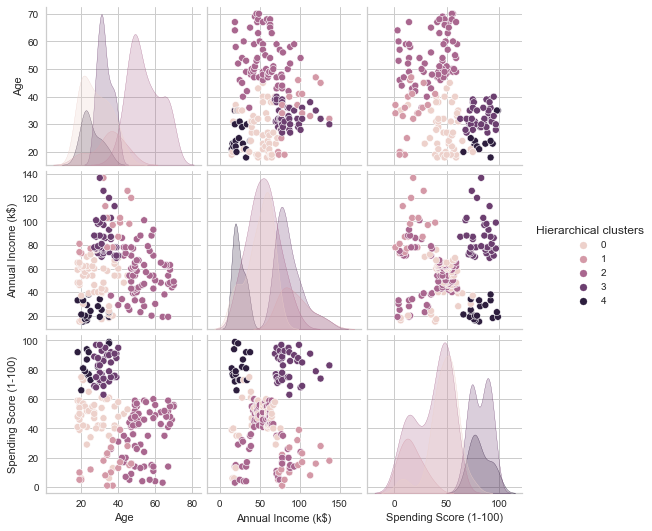

In [30]:
ploting_p = df.drop(columns=['Kmean cluster'],axis=1)
sns.pairplot(ploting_p,hue='Hierarchical clusters')
plt.show()

* We can see clusters with each pair of features. 

In [31]:
#silhoutte score
hc_score = silhouette_score(X,label_hc)
print('Hierarchical cluster silhoutte_score: ',round(hc_score,4))

Hierarchical cluster silhoutte_score:  0.3614


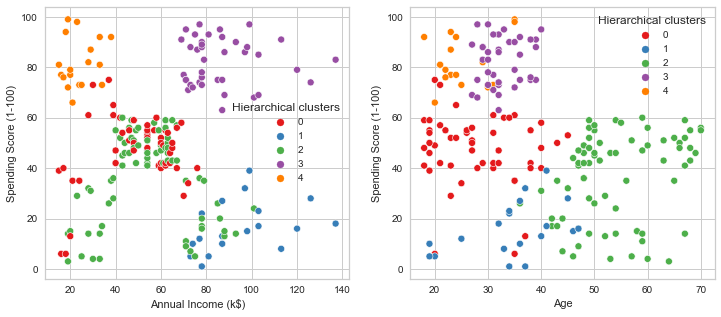

In [32]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=df,
                hue='Hierarchical clusters', ax=axes[0], palette='Set1')

sns.scatterplot('Age', 'Spending Score (1-100)', data=df,
                hue='Hierarchical clusters', palette='Set1', ax=axes[1])


plt.show()

### 3.DBSCAN Clustering

Dbscan hyper parameters are epsilon(radius of circle) and min samples.

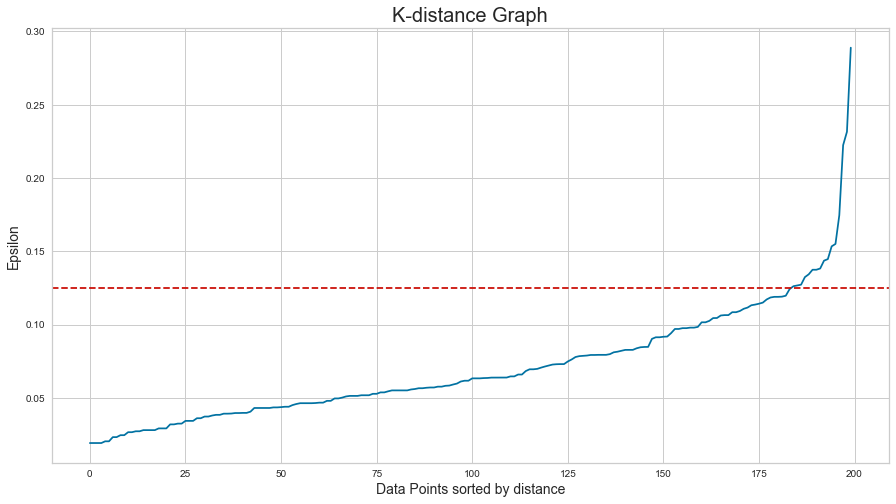

In [33]:
#for Epsilon value..

# Using Knearest neibors to find the distance
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(15,8))
plt.plot(distances)
plt.axhline(y=0.125, color='r', linestyle='--')
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()


* Based on the k distance graph epsilon value is 0.125

In [34]:
# for min_samples
eps=0.125
for min_samples in range(2,20):
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = clusterer.fit_predict(X)

    x= cluster_labels +2
    y = np.bincount(x)
    ii = np.nonzero(y)[0]
    results = list(zip(ii,y[ii]) )
    print('eps=',eps,'| min_samples= ', min_samples, '| obtained clustering: ', results)

eps= 0.125 | min_samples=  2 | obtained clustering:  [(1, 16), (2, 19), (3, 91), (4, 2), (5, 2), (6, 2), (7, 4), (8, 36), (9, 2), (10, 10), (11, 4), (12, 5), (13, 3), (14, 2), (15, 2)]
eps= 0.125 | min_samples=  3 | obtained clustering:  [(1, 28), (2, 19), (3, 91), (4, 4), (5, 36), (6, 10), (7, 4), (8, 5), (9, 3)]
eps= 0.125 | min_samples=  4 | obtained clustering:  [(1, 33), (2, 19), (3, 6), (4, 4), (5, 54), (6, 31), (7, 35), (8, 4), (9, 10), (10, 4)]
eps= 0.125 | min_samples=  5 | obtained clustering:  [(1, 54), (2, 19), (3, 5), (4, 53), (5, 28), (6, 34), (7, 7)]
eps= 0.125 | min_samples=  6 | obtained clustering:  [(1, 63), (2, 18), (3, 51), (4, 29), (5, 32), (6, 7)]
eps= 0.125 | min_samples=  7 | obtained clustering:  [(1, 76), (2, 15), (3, 36), (4, 29), (5, 13), (6, 31)]
eps= 0.125 | min_samples=  8 | obtained clustering:  [(1, 83), (2, 15), (3, 33), (4, 25), (5, 13), (6, 31)]
eps= 0.125 | min_samples=  9 | obtained clustering:  [(1, 97), (2, 15), (3, 28), (4, 21), (5, 9), (6, 30)

* min_samples taken 10 based on the clusters

In [35]:
# building Dbscan with hyper parameters
model_db = DBSCAN(eps=0.125,min_samples=10)
model_db.fit(X)

# predicting clusters
label_db = model_db.labels_

# appending to main dataframe
labels3 =pd.DataFrame(label_db,columns=['dbscan clusters'])
df = pd.concat([df,labels3],axis=1)
df.head(10)

,Age,Annual Income (k$),Spending Score (1-100),Kmean cluster,Hierarchical clusters,dbscan clusters
0,19,15,39,1,0,-1
1,21,15,81,3,4,-1
2,20,16,6,1,0,-1
3,23,16,77,3,4,0
4,31,17,40,1,0,-1
5,22,17,76,3,4,0
6,35,18,6,1,0,-1
7,23,18,94,3,4,-1
8,64,19,3,0,2,-1
9,30,19,72,3,4,0


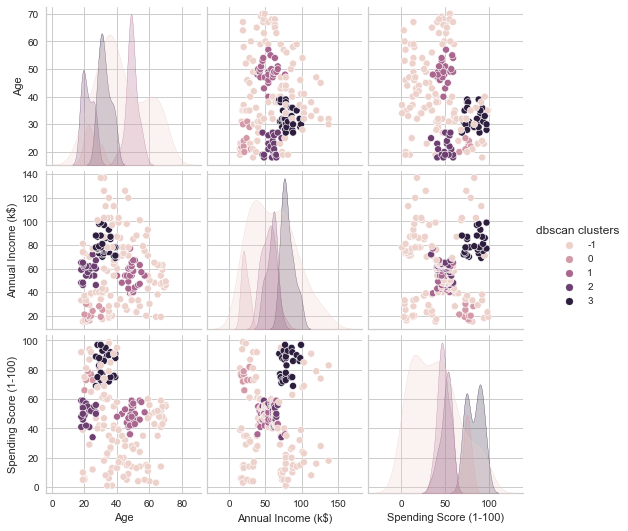

In [36]:
# plotting 
ploting_db = df.drop(columns=['Kmean cluster','Hierarchical clusters'],axis=1)
sns.pairplot(ploting_db,hue='dbscan clusters')
plt.show()

In [37]:
#sihoutte score
score_db = silhouette_score(X,label_db)
print("silhoutte score for DBSCAN: {}".format(round(score_db,3)))

silhoutte score for DBSCAN: 0.072


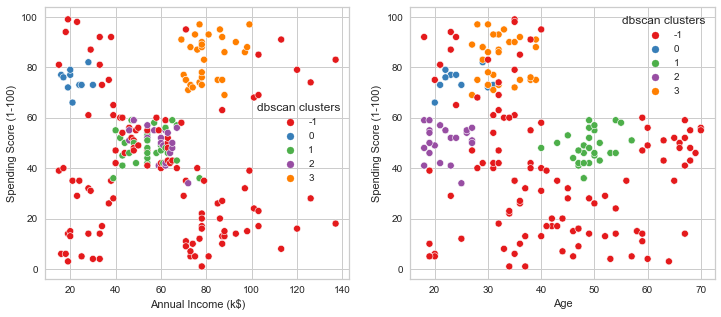

In [38]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=df,
                hue='dbscan clusters', ax=axes[0], palette='Set1')

sns.scatterplot('Age', 'Spending Score (1-100)', data=df,
                hue='dbscan clusters', palette='Set1', ax=axes[1])


plt.show()

* Clusters are not formed well in Dbscan.
* Dbscan basically cluster by densed points as cluster and the spreaded points are considered as outliers.
* It works well for arbitrarily shaped clusters as well as detecting outliers as noise.
* so Dbscan is not suitable for this type of data.

Conclusion:
  * Dbscan is not suitable for this type of data.
  * comparing to KMeans and hierarchical clustering, kmeans clusters are well formed.

    